## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.utils import plot_model
from IPython.display import Image

Using TensorFlow backend.


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

## Upload datasets

In [3]:
filenames = os.listdir(os.path.join(os.getcwd(), 'dataset', 'train'))
df = pd.DataFrame({"filename": filenames})
df['category'] = df["filename"].apply(lambda x: '1' if x[:3] == 'dog' else '0')

In [4]:
df.head()

,filename,category
0,cat.8256.jpg,0
1,dog.4292.jpg,1
2,dog.6779.jpg,1
3,dog.47.jpg,1
4,cat.9392.jpg,0


## Data visualisation

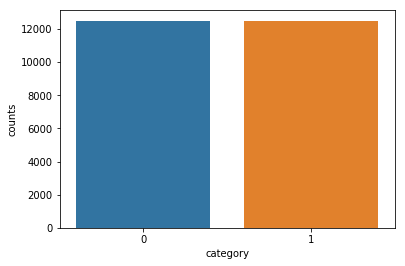

In [5]:
cat_counts = df['category'].value_counts().reset_index().rename({'index': 'category', 'category': 'counts'}, axis=1)
sns.barplot(x=cat_counts['category'], y=cat_counts['counts'])

In [6]:
cat_counts

,category,counts
0,1,12500
1,0,12500


Equal number of dogs and cats in training dataset.

## Few sample images

In [ ]:
np.random.choice(filenames)

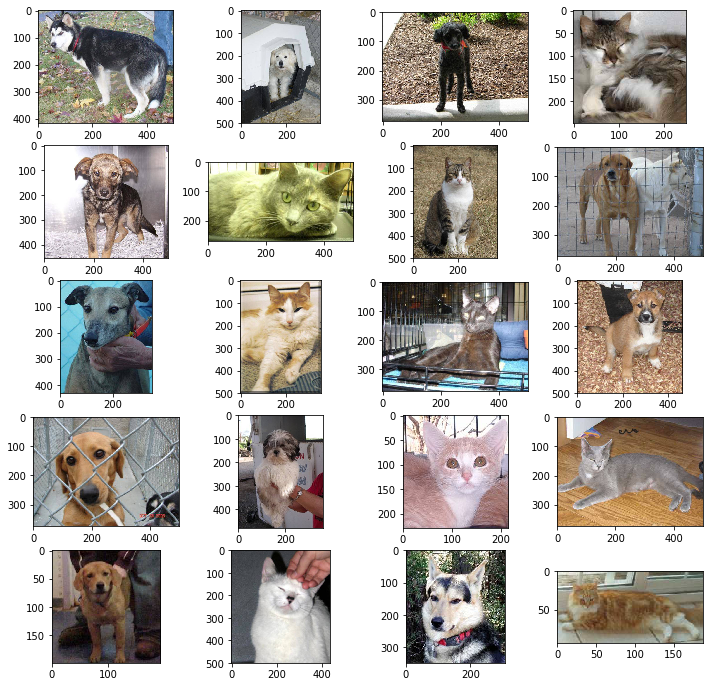

In [7]:
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    sample = np.random.choice(filenames)
    image = load_img(os.path.join(os.getcwd(), 'dataset', 'train', sample))
    plt.imshow(image)
plt.show()

## Build model

In [8]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', 
                 input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = (3,3), activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 512, kernel_size = (3,3), activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dense(512, activation = "relu"))
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1, activation = "softmax"))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


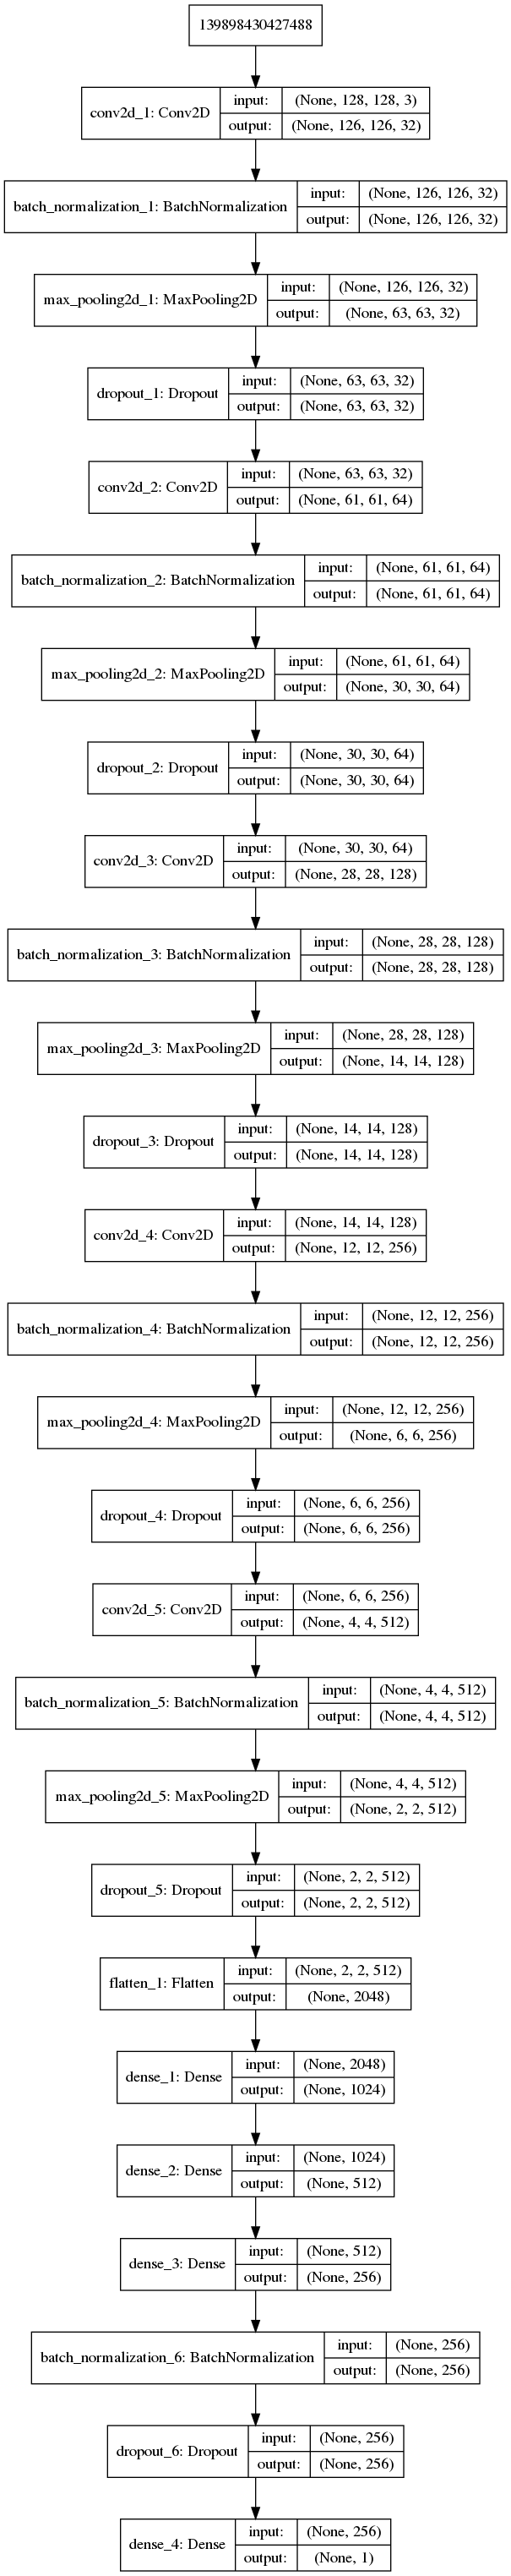

In [9]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image("model.png")

In [ ]:
# # Optimizer
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# # Compile the model
# model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

In [10]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

## Train, validation split

In [11]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [12]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Training generator

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    os.path.join(os.getcwd(), 'dataset', 'train'), 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

validation_generator = train_datagen.flow_from_dataframe(
    validate_df, 
    os.path.join(os.getcwd(), 'dataset', 'train'), 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Visualize generator example

In [15]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    os.path.join(os.getcwd(), 'dataset', 'train'), 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE
)

Found 1 images belonging to 1 classes.


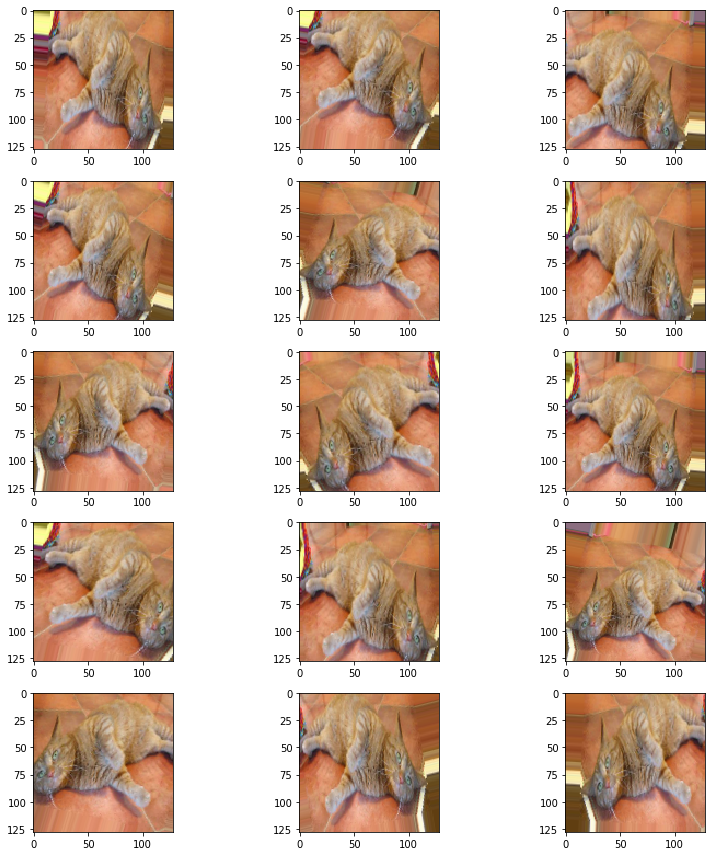

In [16]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit model

In [19]:
epochs = 10

In [ ]:
history = model.fit_generator(
    train_generator, 
    epochs=10,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

In [ ]:
model.save_weights("model.h5")

## Visualize result

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Prepare test dataset

In [ ]:
test_filenames = os.listdir(os.path.join(os.getcwd(), 'dataset', 'test1'))
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Testing generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    os.path.join(os.getcwd(), 'dataset', 'test1'), 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

## Predict

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img(os.path.join(os.getcwd(), 'dataset', 'test1', filename), target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()